# Step 1: Unzip Your Dataset

In [1]:
import zipfile
import os

# Set path to your zip file
zip_path = "/content/compressed_deepfakes.zip"

# Set the directory where you want to extract
extract_dir = "/content/compressed_deepfakes/"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files (optional)
os.listdir(extract_dir)


['__MACOSX', 'compressed_deepfakes']

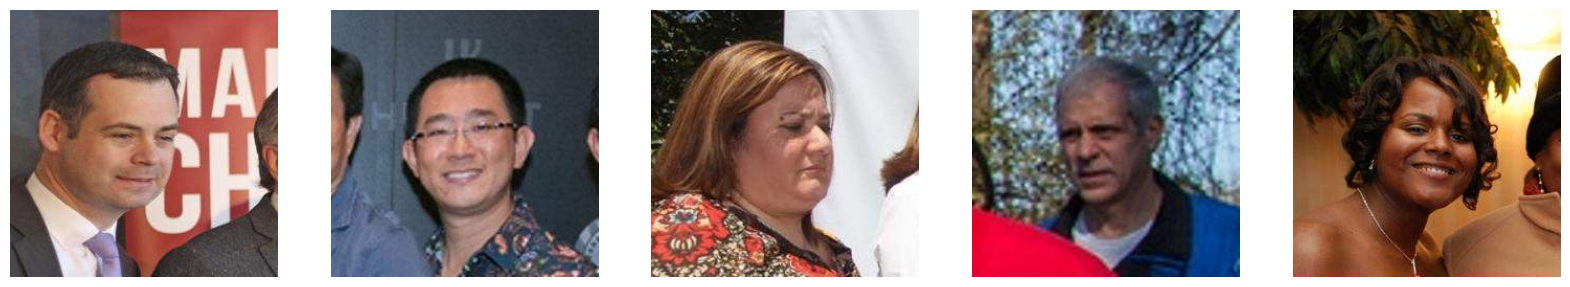

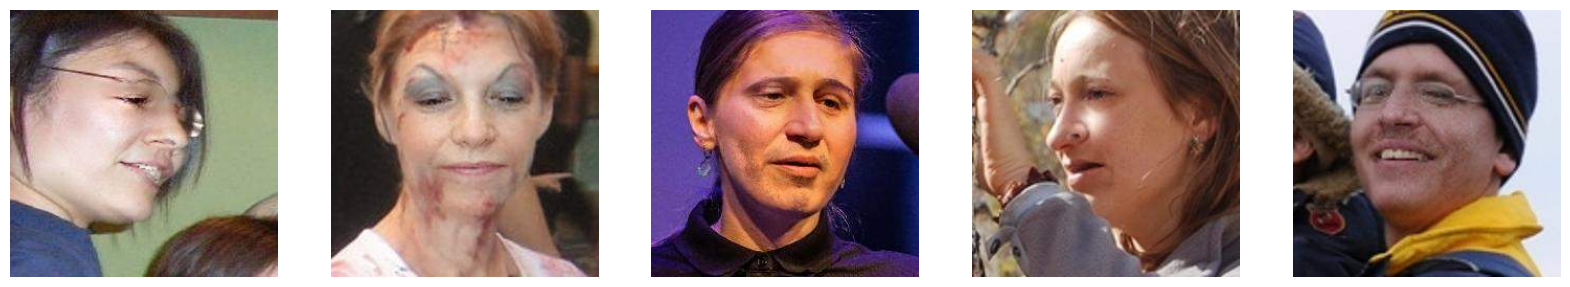

In [11]:
import matplotlib.pyplot as plt
import cv2

def display_sample_images(image_path, n=5):
    categories = ['Real', 'Fake']
    for category in categories:
        folder = os.path.join(image_path, category)
        files = os.listdir(folder)[:n]
        fig, axes = plt.subplots(1, n, figsize=(20, 5))
        for i, file in enumerate(files):
            img = cv2.imread(os.path.join(folder, file))
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
        plt.show()

# Example usage
image_path = "/content/compressed_deepfakes/compressed_deepfakes/test"# Adjust to your dataset path
display_sample_images(image_path)

# Step 2: Image Preprocessing with Keras

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_folder = "/content/compressed_deepfakes/compressed_deepfakes/"

# Set paths
train_path = os.path.join(image_folder, 'train')
val_path = os.path.join(image_folder, 'validation')
test_path = os.path.join(image_folder, 'test')

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation/test
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Step 3: Define the CNN Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Step 4: Train the Model

In [5]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5485 - loss: 0.7406 - val_accuracy: 0.8230 - val_loss: 0.4007
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8347 - loss: 0.3761 - val_accuracy: 0.9170 - val_loss: 0.2148
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8989 - loss: 0.2477 - val_accuracy: 0.9190 - val_loss: 0.2083
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9261 - loss: 0.1983 - val_accuracy: 0.9180 - val_loss: 0.2168
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9333 - loss: 0.1856 - val_accuracy: 0.9180 - val_loss: 0.1925
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9216 - loss: 0.2019 - val_accuracy: 0.9150 - val_loss: 0.2013
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9475 - loss: 0.1512 - val_accuracy: 0.9350 - val_loss: 0.1630
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9353 - loss: 0.1740 - val_accuracy: 0.9380 - val_loss:

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred_probs = model.predict(test_generator)
y_preds = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Report
print(confusion_matrix(y_true, y_preds))
print(classification_report(y_true, y_preds, target_names=class_labels))


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 850ms/step
[[98  2]
 [ 6 94]]
              precision    recall  f1-score   support

        Fake       0.94      0.98      0.96       100
        Real       0.98      0.94      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



This shows the model’s predictions compared to the actual labels:

- **True Positives (Fake predicted as Fake):** 98  
- **False Negatives (Fake predicted as Real):** 2  
- **False Positives (Real predicted as Fake):** 6  
- **True Negatives (Real predicted as Real):** 94  

---

### 📊 **Metrics Breakdown:**

#### **Fake Class:**
- **Precision (0.94):** Out of all images the model predicted as *Fake*, 94% were actually Fake.
- **Recall (0.98):** Out of all actual Fake images, the model correctly identified 98%.
- **F1-score (0.96):** Harmonic mean of precision and recall, indicating strong performance.

#### **Real Class:**
- **Precision (0.98):** Out of all predicted Real images, 98% were actually Real.
- **Recall (0.94):** Out of all actual Real images, 94% were correctly identified.
- **F1-score (0.96):** Again, a balanced and strong score.

---

### ✅ **Overall Performance:**
- **Accuracy (0.96):** The model got 96% of all predictions right.
- **Macro avg (0.96):** Average across both classes (treating them equally).
- **Weighted avg (0.96):** Average that accounts for the number of instances in each class.

---

### 🧠 **Interpretation Summary:**
- The model is **highly accurate** and **balanced**, performing well on both Fake and Real images.
- Slightly better at detecting *Fake* images (higher recall), but extremely strong in both categories.
- Very few errors: only 2 Fakes mislabeled as Real, and 6 Reals mislabeled as Fake.



## Plot Training Curves

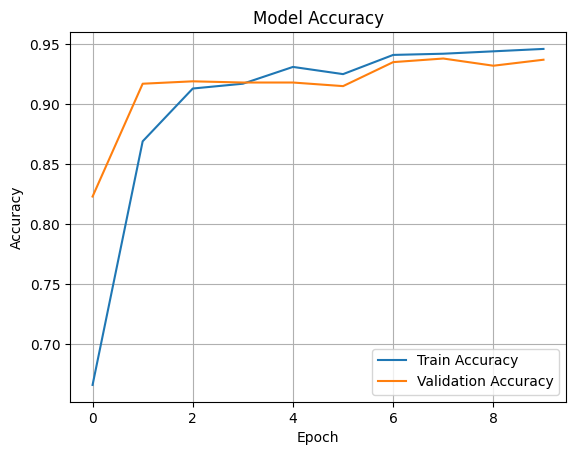

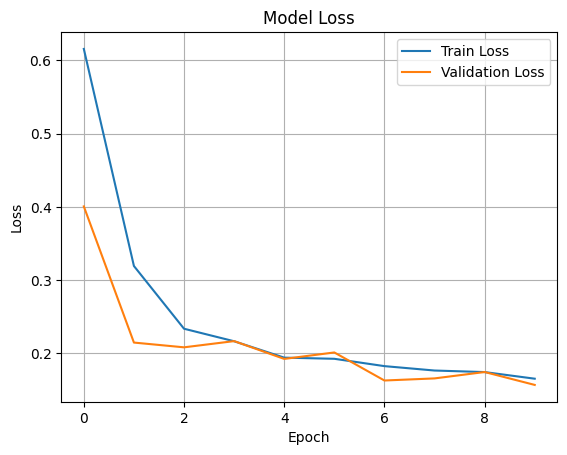

In [7]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


The plot titled **"Model Accuracy"** displays the training and validation accuracy of a model across 10 epochs. At the beginning (epoch 0), training accuracy starts relatively low, around 67%, while validation accuracy begins higher, at approximately 82%. However, the training accuracy improves rapidly over the first few epochs, surpassing 90% by epoch 3. From that point onward, training accuracy continues to improve gradually, reaching about 95% by the final epoch.

Validation accuracy also increases sharply in the early epochs, reaching around 91% by epoch 1, and then continues to fluctuate slightly but remains relatively stable, maintaining values above 91% through the remaining epochs. Notably, validation accuracy appears to slightly trail training accuracy toward the end, with a small but consistent gap—suggesting that while the model generalizes well, there may be a minor overfitting trend developing.

Overall, the model shows strong performance with high accuracy on both the training and validation sets, indicating effective learning with only minimal signs of overfitting.

# Hypothesis Testing

Define Hypotheses


𝑝1: Accuracy of CNN model

𝑝2: Accuracy of baseline (random guessing = 50%)

We test:

Null Hypothesis
𝐻0: 𝑝1 = 𝑝2 =p2 (CNN is no better than random)

Alternative Hypothesis
𝐻1: 𝑝1 > 𝑝2 (CNN is significantly better)

In [8]:
import numpy as np
from scipy.stats import norm

# Observed performance
correct_preds = np.sum(y_preds == y_true)
total_preds = len(y_true)
p1 = correct_preds / total_preds

# Baseline (random guessing)
p2 = 0.5

# Standard error
SE = np.sqrt(p2 * (1 - p2) / total_preds)

# Z-score
z = (p1 - p2) / SE

# p-value
p_value = 1 - norm.cdf(z)  # one-tailed test

print(f"Model accuracy: {p1:.4f}")
print(f"Z-score: {z:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Reject H0: The CNN significantly outperforms random guessing.")
else:
    print("❌ Fail to reject H0: No significant improvement over random guessing.")


Model accuracy: 0.9600
Z-score: 13.0108
P-value: 0.0000
✅ Reject H0: The CNN significantly outperforms random guessing.


The model achieved an accuracy of 96%, meaning it correctly classified 96 out of every 100 images. To statistically evaluate whether this performance is significantly better than random guessing, a Z-test was conducted. The resulting Z-score of 13.01 is extremely high, indicating that the model's accuracy is far from what would be expected by chance. The associated p-value is effectively 0.0000, well below any common significance threshold (e.g., 0.05), which strongly supports the conclusion that the model is not just performing well by luck.

As a result, we confidently reject the null hypothesis (H₀), which assumes that the CNN performs no better than random guessing. This confirms that the model's predictive capabilities are statistically significant and that it truly learns meaningful patterns from the data.